In [37]:
import os
import allel
import zarr
import pandas as pd
import petl as etl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
#import pyfasta
import sys
from os.path import isfile, join, isdir
import dask
# quieten dask warnings about large chunks
dask.config.set(**{'array.slicing.split_large_chunks': True})
import malariagen_data
ag3 = malariagen_data.Ag3("gs://vo_agam_release/")

In [38]:
subpops = 'An.col','An.gam','GM-1','GM-2', 'GW'

In [39]:
pi_fn = '../Data/Extras/pi.windows_eqaccess.h5'
pi = h5py.File(pi_fn, mode='r')


In [40]:
pi['10000']['3L'].keys()

<KeysViewHDF5 ['An.col', 'An.gam', 'GM-1', 'GM-2', 'GW']>

In [59]:
fn_template = 'windows_eqaccess.{window}.{chrom}.txt'

def build_df(chrom, window='1000000'):

    # pi
    pi_fn = '../Data/Extras/pi.windows_eqaccess.h5'
    pi = h5py.File(pi_fn, mode='r')

    # tajima's D
    tjd_fn = '../Data/Extras/Tajimas_D.windows_eqaccess.h5'
    tjd = h5py.File(tjd_fn, mode='r')

    # theta
    tht_fn = '../Data/Extras/theta.windows_eqaccess.h5'
    tht = h5py.File(tht_fn, mode='r')

    pops = subpops
    
    pig = pi[window][chrom]['An.col']
    # N.B., previous data includes final odd-size window, remove here
    windows = pig['windows'][:-1]
    starts = windows[:, 0]
    stops = windows[:, 1]
    midpoints = np.round(windows.mean(axis=1))
    items = [
        ('chrom', [chrom] * len(starts)),
        ('start', starts),
        ('stop', stops),
        ('midpoint', midpoints),
    ]
    
    for pop in pops:
        x = pi[window][chrom][pop]['pi'][:-1]
        items.append(('pi_' + pop, x))

    for pop in pops:
        y = tjd[window][chrom][pop]['tajd'][:-1]
        items.append(('tajima_d_' + pop, y))
        
    for pop in pops:
        y = tht[window][chrom][pop]['theta'][:-1]
        items.append(('theta_' + pop, y))


    df = pd.DataFrame.from_dict(dict(items))

    fn = fn_template.format(window=window, chrom=chrom)
    df.to_csv(fn, sep='\t', index=False)
    
    return df


In [103]:
df = build_df('3L')
df = build_df('3R')

In [104]:
df_3R = pd.read_csv('windows_eqaccess.1000000.3R.txt', sep = '\t')
df_3L = pd.read_csv('windows_eqaccess.1000000.3L.txt', sep = '\t')

In [105]:
new_df_3R = df_3R[((df_3R['start'] > 1000000) & (df_3R['stop'] < 24000000))].drop(columns=(['chrom','start','stop','midpoint']))
new_df_3L = df_3L[((df_3L['start'] > 18000000) & (df_3L['stop'] < 41000000))].drop(columns=(['chrom','start','stop','midpoint']))

In [106]:
frames = [new_df_3R, new_df_3L]
df = pd.concat(frames)

In [107]:
df_pi = df.iloc[:, :5]
df_tjd = df.iloc[:, [5,6,7,8,9]]
df_theta = df.iloc[:, [10,11,12,13,14]]

In [108]:
fn_template = 'windows_dxy_eqaccess_co.{window}.{chrom}.txt'

def build_df(chrom, window='1000000'):

    pi_fn = '../Data/Extras/pi.windows_eqaccess.h5'
    pi = h5py.File(pi_fn, mode='r')
    # theta
    dxy_fn = '../Data/Extras/dxy.windows_eqaccess_ga.h5'
    dxy = h5py.File(dxy_fn, mode='r')

    pops = subpops
    
    pig = pi[window][chrom]['An.col']
    # N.B., previous data includes final odd-size window, remove here
    windows = pig['windows'][:-1]
    starts = windows[:, 0]
    stops = windows[:, 1]
    midpoints = np.round(windows.mean(axis=1))
    items = [
        ('chrom', [chrom] * len(starts)),
        ('start', starts),
        ('stop', stops),
        ('midpoint', midpoints),
    ]
    
    for pop1 in ['GM-1', 'GM-2', 'GW']:
        z = dxy[window][chrom][pop1]['dxy'][:-1]
        items.append(('dxy_' + pop1, z))
        
    df = pd.DataFrame.from_dict(dict(items))

    fn = fn_template.format(window=window, chrom=chrom)
    df.to_csv(fn, sep='\t', index=False)
    
    return df


In [109]:
df = build_df('3L')
df = build_df('3R')

In [110]:
df_3R = pd.read_csv('windows_dxy_eqaccess_co.1000000.3R.txt', sep = '\t')
df_3L = pd.read_csv('windows_dxy_eqaccess_co.1000000.3L.txt', sep = '\t')

In [111]:
new_df_3R = df_3R[((df_3R['start'] > 1000000) & (df_3R['stop'] < 24000000))].drop(columns=(['chrom','start','stop','midpoint']))
new_df_3L = df_3L[((df_3L['start'] > 18000000) & (df_3L['stop'] < 41000000))].drop(columns=(['chrom','start','stop','midpoint']))

In [119]:
frames = [new_df_3R, new_df_3L]
df_dxy_ga = pd.concat(frames)

In [113]:
coldict = {'An.col':'red',
           'An.gam' : 'blue',
           'GM-1' : 'orange',
           'GM-2' : 'green',
           'GW' : 'palegreen',
}
colors = ['red','blue','orange','green','palegreen']
labels = ["An.col","An.gam","GM-1","GM-2","GW"]

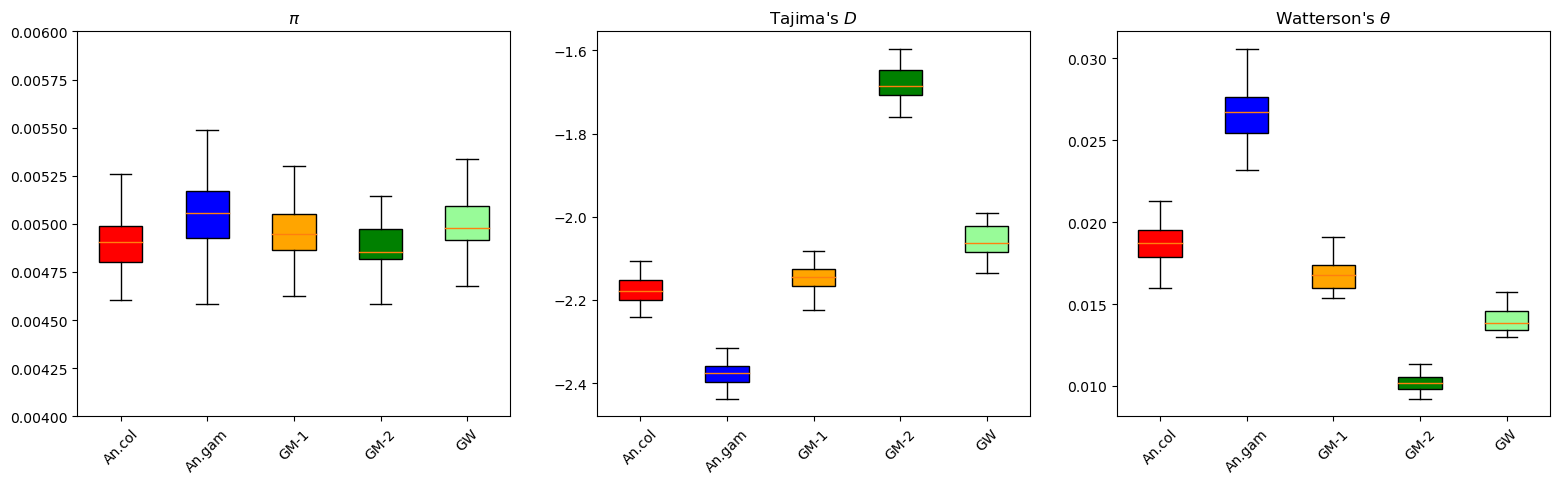

In [114]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(19,5))
boxplot = ax1.boxplot(df_pi,
                     vert=True,  # vertical box alignment
                     patch_artist=colors,  # fill with color
                     labels=labels,
                     showfliers=False)  # will be used to label x-ticks)
ax1.set_title(r'$\pi$')
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)
ax1.set_ylim(0.004, 0.006)
ax1.set_xticklabels(labels, fontdict=None, minor=False, rotation=45)
boxplot2 = ax2.boxplot(df_tjd,
                     vert=True,  # vertical box alignment
                     patch_artist=colors,  # fill with color
                     labels=labels,
                     showfliers=False)  # will be used to label x-ticks)
ax2.set_title(r"Tajima's $D$")
for patch, color in zip(boxplot2['boxes'], colors):
    patch.set_facecolor(color)

ax2.set_xticklabels(labels, fontdict=None, minor=False, rotation=45)

boxplot3 = ax3.boxplot(df_theta,
                     vert=True,  # vertical box alignment
                     patch_artist=colors,  # fill with color
                     labels=labels,
                     showfliers=False)  # will be used to label x-ticks)
ax3.set_title(r"Watterson's $θ$")
ax3.set_xticklabels(labels, fontdict=None, minor=False, rotation=45)


for patch, color in zip(boxplot3['boxes'], colors):
    patch.set_facecolor(color)

fig.savefig('stat1.png')

-----------------------------------

In [116]:
fst = pd.read_csv('/media/storage/Ag1000G/Phase3/Data/Meta/fst_pop.csv',names=['region','pop1','pop2','fst', 'se'], sep = '\t').drop(columns=["region"])
order = ['CO', 'GA','GM-1', 'GM-2', 'GW-1']
#fst.fst = pd.to_numeric(fst['fst'], errors='coerce')
df = fst.pivot(index='pop1', columns='pop2', values='fst')[order]
df = df.fillna(df.T).loc[order]
mask = np.triu(np.ones_like(df, dtype=bool))
cmap = sns.diverging_palette(240, 980, n=10)

In [ ]:
colors = ['purple','purple','purple']
labels = ["GM-1","GM-2","GW"]
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(19,5))

boxplot5 = ax1.boxplot(df_dxy_ga,
                     vert=True,  # vertical box alignment
                     #patch_artist=colors,  # fill with color
                     #labels=labels,
                     showfliers=False)  # will be used to label x-ticks)
ax1.set_title(r"$Dxy$ vs $An. gambiae$")
ax1.set_xticklabels(labels, fontdict=None, minor=False, rotation=45)
ax1.set_ylim(0.004, 0.006)

for patch, color in zip(boxplot3['boxes'], colors):
    patch.set_facecolor(color)
    
boxplot6 = ax2.boxplot(df_dxy_co,
                     vert=True,  # vertical box alignment
                     #patch_artist=colors,  # fill with color
                     #labels=labels,
                     showfliers=False)  # will be used to label x-ticks)
ax2.set_title(r"$Dxy$ vs $An. coluzzii$")
ax2.set_xticklabels(labels, fontdict=None, minor=False, rotation=45)
ax2.set_ylim(0.004, 0.006)


for patch, color in zip(boxplot3['boxes'], colors):
    patch.set_facecolor(color)
    
sns.heatmap(df, mask=mask, cmap=cmap, vmax=.04, center=0,
            square=True, linewidths=.5,annot=True, cbar_kws={"shrink": .5}, ax=ax3)
ax3.set_title(r"Fst")
   
fig.savefig('stat2.png')